## Instrumental Variables in Canonical Demand & Supply Model




### Data-Generating Process



Set up an IV estimator that returns $\beta_{IV} = (Z^T X)^{-1}Z^Ty)$ for some 

In [2]:
import numpy as np
import pandas as pd

def draw_b(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from a function dgp.
    """
    y,X,Z =  dgp(N) # get regression variables
    
    # get projection matrix P = Z(Z'Z)^{-1}Z'
    P = np.dot(Z,np.linalg.inv(Z.T@Z)@Z.T) # dot function needed. Such a pain to figure out (see link)
    # https://stackoverflow.com/questions/17836880/orthogonal-projection-with-numpy
    
    beta_2sls = np.linalg.solve(Z.T@X,Z.T@y) # get beta
    beta_2sls = beta_2sls[1] # for nonconstant term only
    # Note that beta_2sls naturally has 
    #   var(beta(gamma)) = s2 * np.linalg.inv(X.T@P@X) 
    #     where s2 = e.T@e/(N-k)
    #     and e = y - X@beta_2sls - np.asmatrix(df['z']*gamma).T
    
    # A matrix used in question 3.2.2 below
    A = np.linalg.inv( X.T@Z @np.linalg.solve(Z.T@Z,Z.T@X) ) @ X.T@Z # 2x2 matrix
    A = A['z'][1] # get bottom left term of matrix A
    
    return beta_2sls, A

def draw_F(mu_gamma_true):
    """
    Generate a random variate $gamma$ from a sample of 1 draw from any distribution, here normal
    Gamma used in question 3.2.2 below

    """
    # Create noncentered gamma with a normal distribution with sigma_gamma=1 (homoeskedastic) for simplicity
    sigma_gamma_true = 1

    gamma_draw = iid.norm(loc=mu_gamma_true, scale=sigma_gamma_true).rvs(1)
    
    return gamma_draw


### Inference



First note that, under the assumptions of the *model*, a Central Limit Theorem applies so it is asymptotically normal. 

We let the estimator $b$ be a random variable and the data-generating process be such that $Z$ and $X$ have a linear relationship.

## Q 3.2.1: 
Explore how $b(\gamma)$ varies with $\gamma$. Note that, in this model, when $\gamma=0$, $\beta=1$.

In [3]:
from scipy.stats import distributions as iid
from matplotlib import pyplot as plt


def linear_dgp_new(N,beta,gamma,pi,sigma_u,sigma_v):
    u = iid.norm(scale=sigma_u).rvs(N)
    v = iid.norm(scale=sigma_v).rvs(N)
    Z = iid.norm().rvs(N)

    X = Z*pi + v
    y = X*beta + Z*gamma + u  # adding the term Z*gamma

    df = pd.DataFrame({'y':y,'x':X,'z':Z,'Constant':1})
    
    return df[['y']],df[['Constant','x']],df[['Constant','z']] 



Repeatedly draw new random samples and estimate b from them. Note that we assume the true value of beta = 1.


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

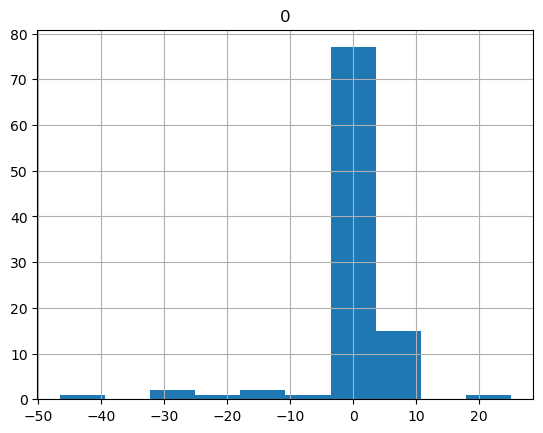

In [4]:

B = pd.DataFrame({}) # create empty dataframe 
gammas = [0] #iterate over list of gammas
for gamma in gammas:
    B[gamma] = pd.DataFrame([draw_b(100,
                                    lambda N: linear_dgp_new(N,1,gamma,.01,1,1))[0] for i in range(100)])
    
B.mean() # print means
B.hist(bins=int(np.ceil(np.sqrt(B.shape[0]))))


With $\gamma \neq 0$, we have the estimates for b shown below. As $\gamma$ moves away from zero, exogeneity is no longer plausible and beta is not centered at its true value of 1.

Repeatedly draw new random samples and calculate b from them

In [5]:
# df of bets_2sls and A
pd.DataFrame([draw_b(100, lambda N: linear_dgp_new(N,1,1,.01,1,1)) for i in range(10)])

,0,1
0,[-13.79916370757091],-14.378693
1,[28.520411461164514],27.949004
2,[-8.235623332916884],-8.860584
3,[37.20297508157369],35.071265
4,[122.13096099865024],112.055649
5,[26.306902737592544],26.581609
6,[28.387316629676246],30.705120
7,[-9.49100473346927],-11.478778
8,[-13.674918580021489],-15.643957
9,[23.6691929408981],23.681623


In [6]:
N_sample = 100
B = pd.DataFrame({}) # create empty dataframe 
gammas = [-100,-1,-0.01,0,0.01,1,100] #iterate over list of gammas
for gamma in gammas:
    B[gamma] = pd.DataFrame([draw_b(N_sample,
                                    lambda N: linear_dgp_new(N,1,gamma,.01,1,1))[0] for i in range(10)])

B.mean() # print means
B

,-100.00,-1.00,-0.01,0.00,0.01,1.00,100.00
0,-1477.812880,-6.520682,-0.021538,0.662727,3.190675,8.274564,-1454.054061
1,-426.050844,-5.913497,0.284967,1.607239,0.439318,10.078317,-22080.751506
2,1192.793072,-15.246178,-0.583398,1.162502,0.807018,12.607188,-603.289930
3,5975.109243,-6.775609,0.423772,0.474916,-4.694349,16.320049,4622.475868
4,-825.794110,550.965678,-0.182401,3.870660,-1.615118,18.124018,-1839.627542
5,356.960362,-178.148660,-3.212276,1.986394,-1.420095,-8.550536,733.350062
6,532.548829,15.481743,-4.079841,7.329226,-0.425519,-32.136964,6236.529807
7,-425.288006,75.714282,8.102512,-20.267703,-2.418063,-4.291770,-6088.853862
8,-643.558269,18.032927,2.140496,-2.914164,0.470285,8.981381,404.573281
9,1438.793824,165.566620,-1.576123,0.464858,-2.474002,-169.461828,550.701843


## Q 3.2.2

To test the null that $b(\gamma) = b(0)=1$, we construct confidence intervals using the variance of $\beta.$ As explained in Conley, Hansen, and Rossi (2012), these confidence intervals can be estimated in four different ways:

1. Union of confidence intervals with $\gamma$ support assumption
2. Union of prior-weighted confidence intervals
3. $\gamma$ local-to-zero approximation
4. Full Bayesian analysis

I opt for the third method where we impose an assumption on the distribution of gamma. 
If we are convinced about the exclusion restriction, then $\gamma=0$ and this exercise is unnecessary. If not, the distrubution of $\beta$ has an additional term, $A\gamma$. That is,

$$\hat{\beta} \sim N(\beta, V_{2SLS}) + A\gamma $$

where $A = (X'Z(Z'Z)^{-1}Z'X)^{-1}(X'Z)$ and $\gamma \sim F$ for some distribution F. 

To test whether $b(\gamma) = b(0)$, we construct $\Delta = \beta - \hat{\beta}$ such that

$
\begin{align}
    \hat{\beta} & \sim N(\beta, V_{2SLS}) + A\gamma \\
    \beta - \hat{\beta} & \sim \beta -  N(\beta, V_{2SLS}) + A\gamma \\
    \Delta & \sim  N(\beta -\beta, V_{2SLS}) + A\gamma \\
    \Delta & \sim  N(0, V_{2SLS}) + A\gamma
\end{align}
$

and follow the five steps below proposed in Conley, Hansen, and Rossi (2012) section III.C. Here we assume for simplicity that $\gamma \sim N(\mu_{\gamma}=0, \sigma_{\gamma}=1)$.

1. Use any standard software package to compute A and the 2SLS covariance matrix $V_{2SLS}$.
2. Generate one draw, $\Delta_1$, from the desired distribution by generating a $N(0, V_{2SLS})$ draw and adding it to A times a draw from F.
3. Repeat step 2 B times for some large number B to generate a set of $\Delta$ draws: $\Delta_1$, $\Delta_2$, ... ,$\Delta_B$.
4. Compute percentiles of the B draws to use for confidence intervals. For example, find the $\alpha/2$ and $1 − \alpha/2$ percentiles, and label them $c_{\alpha/2}$ and $c_{1−\alpha/2}$, respectively.
5. Construct a $(1 − \alpha)$, confidence interval for $\beta$ as [$\hat{\beta} - c_{1−\alpha/2}$,  $\hat{\beta}-c_{\alpha/2}]$.


In [7]:
N_sample = 100
delta = pd.DataFrame({}) # create empty dataframe 
gammas = [0.1] #iterate over list of gammas

# Steps 1 - 3
for gamma in gammas:
    
    # Draw values of beta from 2sls as before and
    # Draw values of gamma assuming a normal distribution defined in draw_F
    
    temp = pd.DataFrame([draw_b(N_sample,lambda N: linear_dgp_new(N,1,gamma,.01,1,1)) for i in range(1000)])
    beta = np.float32(temp[0]) # np.float needed for quantile function below
    A = np.float32(temp[1])

    delta[gamma] = beta + draw_F(gamma)*A 
    
delta.mean() # print means

0.1    0.764332
dtype: float64

array([[<AxesSubplot:title={'center':'0.1'}>]], dtype=object)

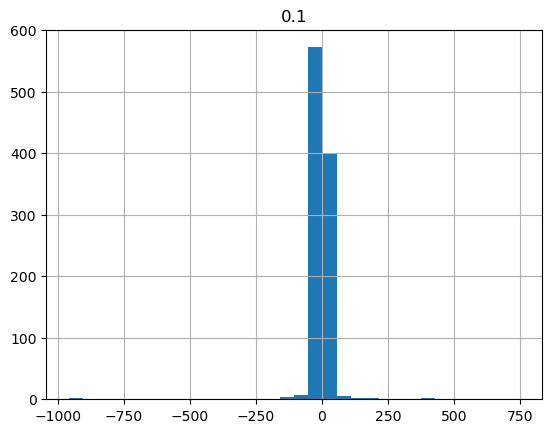

In [11]:
# plot histogram for given value of gamma
delta.hist(bins=int(np.ceil(np.sqrt(delta.shape[0]))))

Compute percentiles of the B draws to use for confidence intervals. That is, find the $\alpha/2$ and $1 − \alpha/2$ percentiles, and label them $c_{\alpha/2}$ and $c_{1−\alpha/2}$, respectively.

In [14]:
# Step 4
confidence = 0.95
alpha = 1 - confidence
c_a2 = np.float32(delta.quantile(alpha/2))
c_1_less_a2 = np.float32(delta.quantile(1-alpha/2))
c_a2, c_1_less_a2

(array([-32.8975], dtype=float32), array([29.801739], dtype=float32))

We construct a $(1 − \alpha)$, confidence interval for $\beta$ as [$\hat{\beta} - c_{1−\alpha/2}$,  $\hat{\beta}-c_{\alpha/2}]$.

In [9]:
# Step 5
# beta_hat = beta-delta
beta_hat = 1 - delta.mean() # not sure about this step. What is beta_hat?
CI = beta_hat - c_1_less_a2, beta_hat - c_a2
CI

(0.1   -29.566071
 dtype: float64,
 0.1    33.133167
 dtype: float64)

We cannot reject the null hypothesis that $b(\gamma)=b(0)$.

## Q 3.2.3

We extend the analysis from the previous question. Instead of setting $\gamma$ directly, here we set the covariance between the instrument $Z$ and the endogenous regressor $X$. Recall that $\gamma=Cov(Z,X)/Var(Z)$.

To test the null that $b(\gamma) = b(0)=1$ in this case, it is easier to use the union of confidence intervals approach. We start with a list of plausible values for $Cov(Z,X)=\sigma_{Z,X}$. For each value in the lest, we compute $\gamma$ and the associated confidence interval. Then we take the union of these confidence intervals.
